In [1]:
import torch, torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from tqdm import tqdm


In [11]:
# set environemtn PYTORCH_ENABLE_MPS_FALLBACK=1
device = "cpu"
# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")

# else:
#     device = torch.device("mps")

# use cuda:0 if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device

device(type='cuda', index=0)

In [12]:
T = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])
train_set = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
print(train_set)
test_set = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [13]:
BATCH_SIZE = 64
train_dl = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_set, batch_size = 1, shuffle=True)

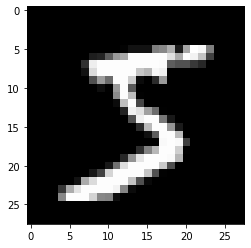

In [14]:
plt.imshow(train_set[0][0][0], cmap="gray")

# Flattened AE

In [15]:
class MNIST_AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(16, 2)

        self.decoder = torch.nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1,[28,28])
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        bottlenecked = self.bottleneck(encoded)

        decoded = self.decoder(bottlenecked)
        return decoded, bottlenecked

In [16]:
# INSTANTIATE NEW
LOAD = True
auto_encoder = None
if LOAD:
  auto_encoder = torch.load("auto_encoder_flattened.pt")
  print(auto_encoder.eval())
else:
  auto_encoder = MNIST_AE()
  print(auto_encoder.eval())


MNIST_AE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=16, bias=True)
    (8): ReLU()
  )
  (bottleneck): Linear(in_features=16, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=784, bias=True)
    (9): Sigmoid()
    (10): Unflatten(dim=1, unflattened_size=[28, 28])
  )
)


In [ ]:
EPOCHS = 100
auto_encoder = auto_encoder.to(device)
optimizer = torch.optim.Adam(auto_encoder.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    images = torch.squeeze(images)
    labels = labels.to(device)
    pred, bottlenecked = auto_encoder(images)

    #DISPLAY IMAGE
    if j == 0 and i % 10 == 0:
      plt.imshow(images[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(pred[0]).detach().numpy(), cmap = "gray")
      plt.show()

    #RMSE
    loss = torch.sqrt(criterion(pred, images))
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(auto_encoder, "auto_encoder_flattened.pt")

In [17]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    auto_encoder.eval()
    with torch.no_grad():
       _, encoded_img  = auto_encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:38<00:00, 257.71it/s]


In [18]:
def plot_ae_outputs(ae ,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
      with torch.no_grad():
         rec_img, _  = ae(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

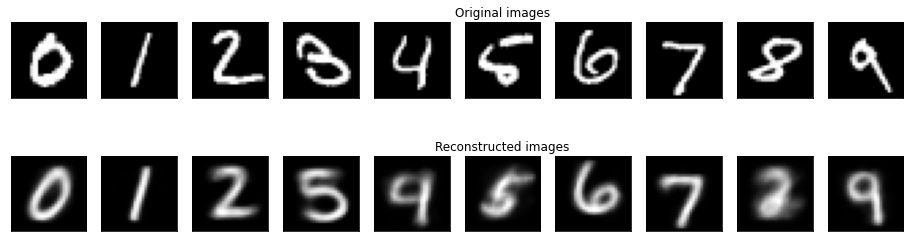

In [19]:
plot_ae_outputs(auto_encoder)

# Convolutional AE

In [20]:
class MNIST_CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )

        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(16, 2)

        self.decoder_dense = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 3 * 3 * 32),
            nn.Unflatten(1, [32, 3, 3])
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder_conv = self.encoder_conv(x)
        encoder_dense = self.encoder_dense(encoder_conv)
        bottlenecked = self.bottleneck(encoder_dense)
        decoder_dense = self.decoder_dense(bottlenecked)
        decoder_conv = self.decoder_conv(decoder_dense)
        return decoder_conv, bottlenecked


In [21]:
# INSTANTIATE NEW
LOAD = True
cae = None
if LOAD:
  cae = torch.load("cae.pt")
  print(cae.eval())
else:
  cae = MNIST_CAE()
  print(cae.eval())


MNIST_CAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
  )
  (bottleneck): Linear(in_features=16, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3

  0%|          | 0/5 [00:00<?, ?it/s]

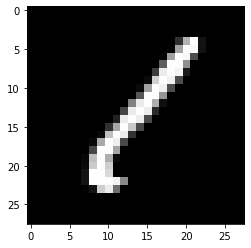

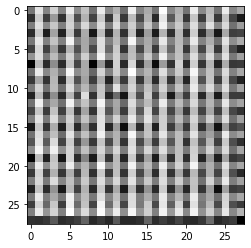

 20%|██        | 1/5 [00:34<02:17, 34.30s/it]

0.2582106986788036


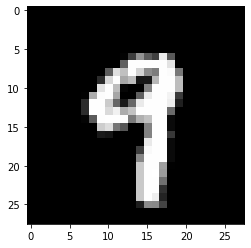

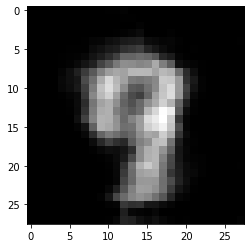

 40%|████      | 2/5 [01:07<01:41, 33.91s/it]

0.22441743361924502


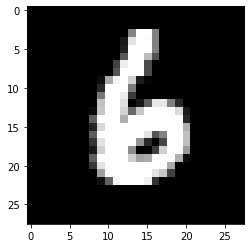

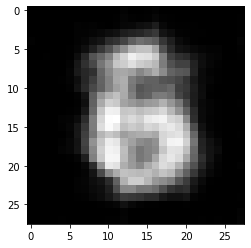

 60%|██████    | 3/5 [01:40<01:06, 33.36s/it]

0.2163561871056872


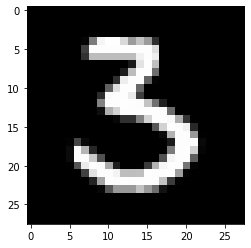

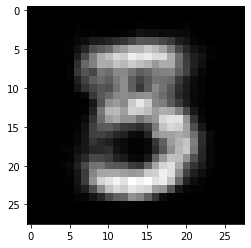

 80%|████████  | 4/5 [02:10<00:31, 31.96s/it]

0.21098872085115802


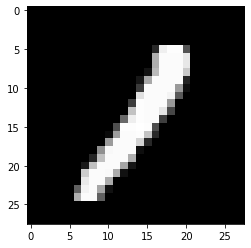

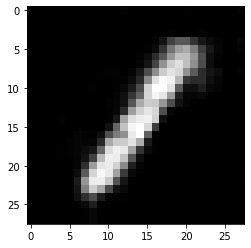

100%|██████████| 5/5 [02:38<00:00, 31.77s/it]

0.20777774645067226


In [150]:
torch.manual_seed(42)

EPOCHS = 5
cae = cae.to(device)
optimizer = torch.optim.Adam(cae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    labels = labels.to(device)
    pred, bottlenecked = cae(images)

    #DISPLAY IMAGE
    if j == 0:
      plt.imshow(torch.squeeze(images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()

    #RMSE
    loss = torch.sqrt(criterion(pred, images))
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(cae, "cae.pt")

In [22]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    cae.eval()
    with torch.no_grad():
       _, encoded_img  = cae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:48<00:00, 206.83it/s]


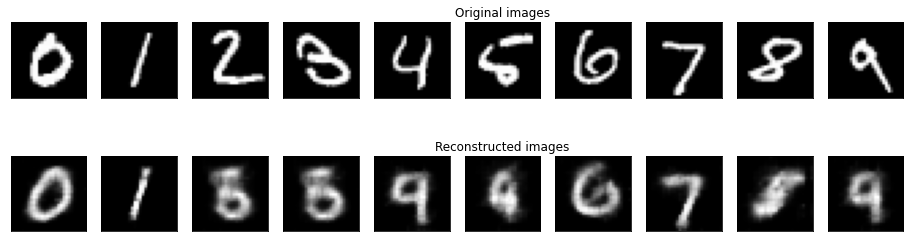

In [23]:
plot_ae_outputs(cae)

# Denoising

In [24]:
# INSTANTIATE NEW
LOAD = True
cae_denoising = None
if LOAD:
  cae_denoising = torch.load("cae_denoising.pt")
  print(cae_denoising.eval())
else:
  cae_denoising = MNIST_CAE()
  print(cae_denoising.eval())


MNIST_CAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
  )
  (bottleneck): Linear(in_features=16, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3

  0%|          | 0/5 [00:00<?, ?it/s]

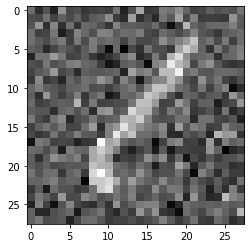

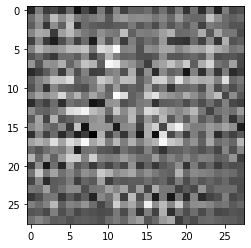

 20%|██        | 1/5 [00:35<02:22, 35.73s/it]

0.26081483669753774


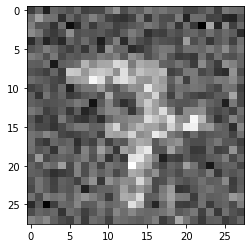

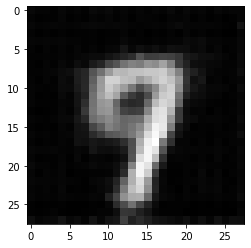

 40%|████      | 2/5 [01:11<01:47, 35.88s/it]

0.20904637803273923


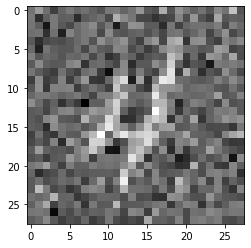

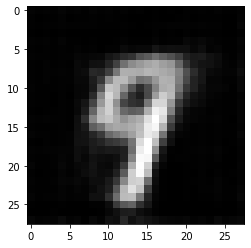

 60%|██████    | 3/5 [01:44<01:08, 34.42s/it]

0.20362893738217955


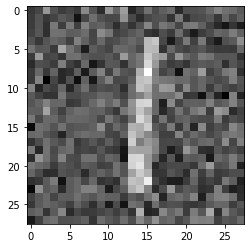

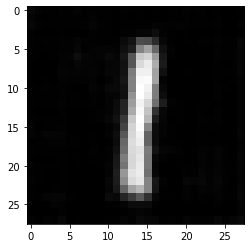

 80%|████████  | 4/5 [02:17<00:33, 33.73s/it]

0.2005863962079416


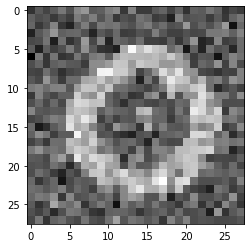

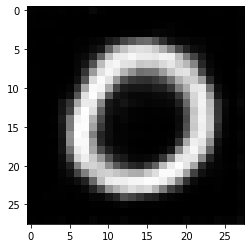

100%|██████████| 5/5 [02:50<00:00, 34.11s/it]

0.1994181098237729


In [167]:
torch.manual_seed(42)

EPOCHS = 10
cae_denoising = cae_denoising.to(device)
optimizer = torch.optim.Adam(cae_denoising.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    labels = labels.to(device)
    noise = (torch.randn(images.size())*0.2).to(device)
    noisy_images = images + noise
    pred, bottlenecked = cae_denoising(noisy_images)
    #DISPLAY IMAGE
    if j == 0:
      plt.imshow(torch.squeeze(noisy_images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()

    #RMSE
    loss = torch.sqrt(criterion(pred, images))
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(cae_denoising, "cae_denoising.pt")

In [25]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    noise = (torch.randn(img.size())*0.4).to(device)
    noisy_images = img + noise
    label = sample[1]
    # Encode image
    cae_denoising.eval()
    with torch.no_grad():
       _, encoded_img  = cae_denoising(noisy_images)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:52<00:00, 190.07it/s]


In [42]:
def plot_dae_outputs(ae ,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
      noise = (torch.randn(img.size())*0.4).to(device)
      noisy_images = img + noise
      with torch.no_grad():
         rec_img, _  = ae(noisy_images)
      plt.imshow(noisy_images.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Noisy images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

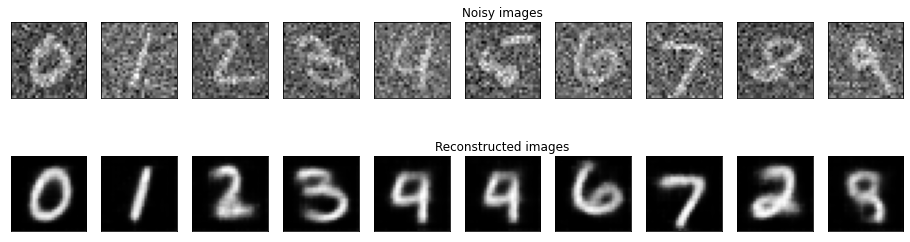

In [43]:
plot_dae_outputs(cae_denoising)